In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
import itertools
import importlib
import time

In [31]:
from training import toy
importlib.reload(toy)
torch.manual_seed(42)

batch_size = 2

trainset = toy.CubicToyDataset(min=-4, max=4, sample_count=20, noise=3, normalize=True, offset=50)
#trainset = toy.TrigonometricToyDataset(sample_count=200, normalize=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

device = torch.device("cpu")

Epoch 0: loss 0.06276226788759232
Epoch 100: loss 0.002218063222244382
Final loss 0.0016113042365759611
RMSE 174.53414916992188


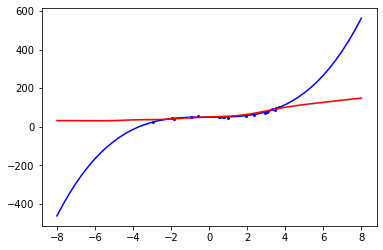

In [32]:
# Point estimator with L2 regularization

torch.manual_seed(42)

model = nn.Sequential(
    nn.Linear(1, 100), 
    nn.ReLU(),
    nn.Linear(100, 1)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)
for epoch in range(160):
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")
trainset.plot(lambda input: (model(input), torch.tensor(0)))

Epoch 0: loss 0.06276226788759232
Epoch 100: loss 0.002218063222244382
Final loss 0.0016113042365759611
RMSE 181.13619995117188


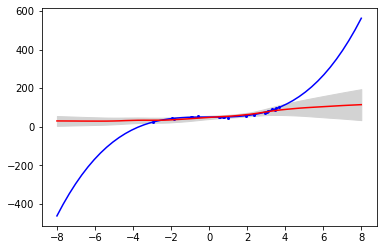

In [35]:
# SWAG trained with SGD and L2 regularization (lr is currently not adjusted for SWAG)

from training import swag
importlib.reload(swag)

torch.manual_seed(42)

model = nn.Sequential(
    nn.Linear(1, 100), 
    nn.ReLU(), 
    nn.Linear(100, 1)
)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001) # Without weight_decay the covariance matrix is not positive definit???
wrapper = swag.SWAGWrapper(model, 5, 10)

for epoch in range(160):
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    wrapper.update(epoch)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")

def eval_swag(input):
    return wrapper.sample(input, 100, model, 1)

trainset.plot(eval_swag)

Training model 0
  Epoch 0: loss 0.054125815629959106
  Epoch 100: loss 0.002052833093330264
  Final loss 0.001764992019161582
Training model 1
  Epoch 0: loss 0.07887625694274902
  Epoch 100: loss 0.0013792330864816904
  Final loss 0.0011256973957642913
Training model 2
  Epoch 0: loss 0.022096000611782074
  Epoch 100: loss 0.0014610444195568562
  Final loss 0.0012081372551620007
Training model 3
  Epoch 0: loss 0.03444146737456322
  Epoch 100: loss 0.0023843247909098864
  Final loss 0.0019207779550924897
Training model 4
  Epoch 0: loss 0.0658072903752327
  Epoch 100: loss 0.0017270457465201616
  Final loss 0.0015321813989430666
RMSE 167.49778747558594


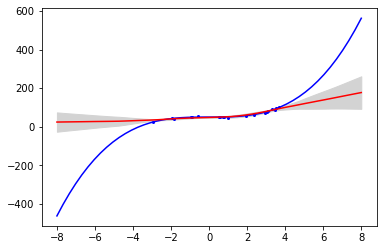

In [40]:
# Ensemble of point estimators with L2 regularization

from training import ensemble
importlib.reload(ensemble)

torch.manual_seed(42)

ensemble_count = 5
models = [nn.Sequential(
    nn.Linear(1, 100), 
    nn.ReLU(), 
    nn.Linear(100, 1)
) for _ in range(ensemble_count)]

for i, model in enumerate(models):
    print(f"Training model {i}")
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)
    for epoch in range(160):
        epoch_loss = torch.tensor(0, dtype=torch.float)
        for data, target in trainloader:
            optimizer.zero_grad()

            output = model(data)
            loss = F.mse_loss(output, target)

            loss.backward()
            optimizer.step()
            epoch_loss += loss
        if epoch % 100 == 0:
            print(f"  Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
    print(f"  Final loss {epoch_loss / (len(trainloader) * batch_size)}")


def eval_esemble(input):
    outputs = torch.stack([model(input) for model in models])
    return torch.mean(outputs, dim=0), torch.var(outputs, dim=0)
trainset.plot(eval_esemble)

Epoch 0: loss 0.04467980936169624
Epoch 100: loss 0.004624450579285622
Final loss 0.0029873698949813843
RMSE 149.7764434814453


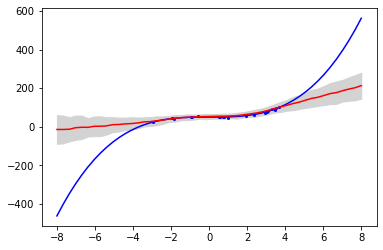

In [41]:
# MC dropout

torch.manual_seed(42)

p = 0.3

model = nn.Sequential(
    nn.Linear(1, 300), 
    nn.ReLU(), 
    nn.Dropout(p),
    nn.Linear(300, 1),
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(160):
    model.train()
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")

def eval_dropout(input):
    samples = 100
    model.train() # Enable dropout
    outputs = torch.stack([model(input) for _ in range(samples)])
    return torch.mean(outputs, dim=0), torch.var(outputs, dim=0)

trainset.plot(eval_dropout)

Epoch 0: loss 27.895885467529297
Epoch 100: loss 27.71942138671875
Final loss 27.715219497680664
RMSE 198.28761291503906


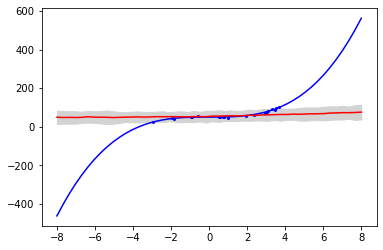

In [42]:
# Bayesian NN (Bayes-by-Backprop)

from training import bbb, util
importlib.reload(bbb)
importlib.reload(util)

torch.manual_seed(42)

pi = 0.5  # 0.25, 0.5, 0.75
sigma1 = np.exp(-1)  # 0, 1, 2
sigma2 = np.exp(-7)  # 6, 7, 8
#prior = util.GaussianMixture(pi, sigma1, sigma2)
prior = torch.distributions.Normal(0, 1.0)

model = nn.Sequential(
    bbb.BBBLinear(1, 100, prior, prior, device, mc_sample=2, sampling="activations"),
    nn.ReLU(),
    bbb.BBBLinear(100, 1, prior, prior, device, mc_sample=2, sampling="activations")
)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

for epoch in range(160):
    loss = bbb.run_bbb_epoch(model, optimizer, loss_fn, trainloader, device)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss {loss / (len(trainloader) * batch_size)}")
print(f"Final loss {loss / (len(trainloader) * batch_size)}")


def eval_bbb(input):
    samples = 100
    model.eval()
    outputs = torch.stack([model(input) for _ in range(samples)])
    return torch.mean(outputs, dim=0), torch.var(outputs, dim=0)
trainset.plot(eval_bbb)